COCO DATA SET에서 BLADE 라벨링 필터링(블레이드 only)

In [8]:
# 셀 1: 환경 설정
import sys
import json
from pathlib import Path
import shutil

sys.path.append('.')
from LabelingEditorFunctions import (
    extract_blade_only,
    extract_damage_only,
    check_categories
)

# 경로 설정
coco_seg_root = Path(r'C:\EngineBladeAI\EngineInspectionAI_MS\data\coco_segmentation_for_multilabel')

print("="*60)
print("COCO Segmentation 데이터 처리")
print("="*60)
print(f"경로: {coco_seg_root}")

# 폴더 구조 확인
for split in ['train', 'valid', 'test']:
    split_dir = coco_seg_root / split
    if split_dir.exists():
        # JSON 파일 확인
        json_files = list(split_dir.glob('*.json'))
        img_files = list(split_dir.glob('*.jpg')) + list(split_dir.glob('*.png'))
        print(f"{split}: {len(img_files)} images, {len(json_files)} JSON files")
        
        # JSON 파일 이름 출력
        for jf in json_files:
            print(f"  - {jf.name}")
    else:
        print(f"{split}: 폴더 없음")

COCO Segmentation 데이터 처리
경로: C:\EngineBladeAI\EngineInspectionAI_MS\data\coco_segmentation_for_multilabel
train: 496 images, 1 JSON files
  - _annotations.coco.json
valid: 150 images, 1 JSON files
  - _annotations.coco.json
test: 120 images, 1 JSON files
  - _annotations.coco.json


In [9]:
# 셀 2: COCO JSON 파일 찾기 및 확인
print("\n" + "="*60)
print("COCO JSON 파일 확인")
print("="*60)

coco_json_files = {}

for split in ['train', 'valid', 'test']:
    split_dir = coco_seg_root / split
    
    if not split_dir.exists():
        continue
    
    # 일반적인 COCO annotation 파일명들
    possible_names = [
        '_annotations.coco.json',
        'annotations.json',
        '_annotations.json',
        f'{split}.json',
        'instances_default.json',
        'via_region_data.json'
    ]
    
    json_file = None
    for name in possible_names:
        candidate = split_dir / name
        if candidate.exists():
            json_file = candidate
            break
    
    # 못 찾으면 첫 번째 JSON 파일 사용
    if json_file is None:
        json_files = list(split_dir.glob('*.json'))
        if json_files:
            json_file = json_files[0]
    
    if json_file:
        coco_json_files[split] = json_file
        print(f"{split}: {json_file.name} 사용")
        
        # 내용 확인
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        print(f"  - Images: {len(data.get('images', []))}개")
        print(f"  - Annotations: {len(data.get('annotations', []))}개")
        print(f"  - Categories: {[cat['name'] for cat in data.get('categories', [])]}")
    else:
        print(f"{split}: ❌ JSON 파일 없음")


COCO JSON 파일 확인
train: _annotations.coco.json 사용
  - Images: 496개
  - Annotations: 2187개
  - Categories: ['objects', 'Blade', 'Crack', 'Nick', 'Tear']
valid: _annotations.coco.json 사용
  - Images: 150개
  - Annotations: 484개
  - Categories: ['objects', 'Blade', 'Crack', 'Nick', 'Tear']
test: _annotations.coco.json 사용
  - Images: 120개
  - Annotations: 510개
  - Categories: ['objects', 'Blade', 'Crack', 'Nick', 'Tear']


In [10]:
# 셀 3: 카테고리 상세 확인
print("\n" + "="*60)
print("카테고리 상세 정보")
print("="*60)

for split, json_file in coco_json_files.items():
    print(f"\n{split} ({json_file.name}):")
    
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # 카테고리별 annotation 수 계산
    cat_counts = {}
    for cat in data['categories']:
        cat_counts[cat['id']] = {'name': cat['name'], 'count': 0}
    
    for ann in data['annotations']:
        if ann['category_id'] in cat_counts:
            cat_counts[ann['category_id']]['count'] += 1
    
    # 출력
    for cat_id, info in cat_counts.items():
        print(f"  ID {cat_id}: {info['name']} = {info['count']}개")


카테고리 상세 정보

train (_annotations.coco.json):
  ID 0: objects = 0개
  ID 1: Blade = 857개
  ID 2: Crack = 354개
  ID 3: Nick = 815개
  ID 4: Tear = 161개

valid (_annotations.coco.json):
  ID 0: objects = 0개
  ID 1: Blade = 249개
  ID 2: Crack = 0개
  ID 3: Nick = 133개
  ID 4: Tear = 102개

test (_annotations.coco.json):
  ID 0: objects = 0개
  ID 1: Blade = 206개
  ID 2: Crack = 76개
  ID 3: Nick = 184개
  ID 4: Tear = 44개


In [11]:
# 셀 4: Blade만 추출
print("\n" + "="*60)
print("Step 1: Blade만 추출")
print("="*60)

blade_total = 0

for split, json_file in coco_json_files.items():
    output_file = json_file.parent / 'blade_only.json'
    
    print(f"\n{split} 처리 중...")
    result = extract_blade_only(str(json_file), str(output_file))
    
    if result:
        with open(output_file, 'r') as f:
            blade_data = json.load(f)
        count = len(blade_data['annotations'])
        blade_total += count
        print(f"  ✅ blade_only.json 생성 완료: {count}개 annotations")
    else:
        print(f"  ⚠️ Blade 카테고리 없음")

print(f"\n총 Blade annotations: {blade_total}개")


Step 1: Blade만 추출

train 처리 중...

📁 파일: _annotations.coco.json
원본 카테고리: ['objects', 'Blade', 'Crack', 'Nick', 'Tear']
전체 annotations: 2187
✅ Blade annotations: 857
  ✅ blade_only.json 생성 완료: 857개 annotations

valid 처리 중...

📁 파일: _annotations.coco.json
원본 카테고리: ['objects', 'Blade', 'Crack', 'Nick', 'Tear']
전체 annotations: 484
✅ Blade annotations: 249
  ✅ blade_only.json 생성 완료: 249개 annotations

test 처리 중...

📁 파일: _annotations.coco.json
원본 카테고리: ['objects', 'Blade', 'Crack', 'Nick', 'Tear']
전체 annotations: 510
✅ Blade annotations: 206
  ✅ blade_only.json 생성 완료: 206개 annotations

총 Blade annotations: 1312개


In [12]:
# 셀 5: 손상만 추출 (Blade 제외)
print("\n" + "="*60)
print("Step 2: 손상만 추출 (Blade 제외)")
print("="*60)

damage_total = 0

for split, json_file in coco_json_files.items():
    output_file = json_file.parent / 'damage_only.json'
    
    print(f"\n{split} 처리 중...")
    result = extract_damage_only(str(json_file), str(output_file))
    
    if result:
        with open(output_file, 'r') as f:
            damage_data = json.load(f)
        count = len(damage_data['annotations'])
        damage_total += count
        print(f"  ✅ damage_only.json 생성 완료: {count}개 annotations")
        
        # 손상 종류별 통계
        damage_cats = {cat['name']: cat['id'] for cat in damage_data['categories']}
        damage_dist = {name: 0 for name in damage_cats}
        
        for ann in damage_data['annotations']:
            for name, cat_id in damage_cats.items():
                if ann['category_id'] == cat_id:
                    damage_dist[name] += 1
        
        for name, cnt in damage_dist.items():
            print(f"    - {name}: {cnt}개")
    else:
        print(f"  ⚠️ 손상 카테고리 없음")

print(f"\n총 손상 annotations: {damage_total}개")


Step 2: 손상만 추출 (Blade 제외)

train 처리 중...

📁 파일: _annotations.coco.json
원본 카테고리: [(0, 'objects'), (1, 'Blade'), (2, 'Crack'), (3, 'Nick'), (4, 'Tear')]
손상 카테고리: ['Crack', 'Nick', 'Tear']
✅ 손상 annotations: 1330
  ✅ damage_only.json 생성 완료: 1330개 annotations
    - Crack: 354개
    - Nick: 815개
    - Tear: 161개

valid 처리 중...

📁 파일: _annotations.coco.json
원본 카테고리: [(0, 'objects'), (1, 'Blade'), (2, 'Crack'), (3, 'Nick'), (4, 'Tear')]
손상 카테고리: ['Crack', 'Nick', 'Tear']
✅ 손상 annotations: 235
  ✅ damage_only.json 생성 완료: 235개 annotations
    - Crack: 0개
    - Nick: 133개
    - Tear: 102개

test 처리 중...

📁 파일: _annotations.coco.json
원본 카테고리: [(0, 'objects'), (1, 'Blade'), (2, 'Crack'), (3, 'Nick'), (4, 'Tear')]
손상 카테고리: ['Crack', 'Nick', 'Tear']
✅ 손상 annotations: 304
  ✅ damage_only.json 생성 완료: 304개 annotations
    - Crack: 76개
    - Nick: 184개
    - Tear: 44개

총 손상 annotations: 1869개


In [13]:
# 셀 6: 결과 요약
print("\n" + "="*60)
print("처리 결과 요약")
print("="*60)

summary = {
    'split': [],
    'original': [],
    'blade': [],
    'damage': []
}

for split in ['train', 'valid', 'test']:
    split_dir = coco_seg_root / split
    
    if not split_dir.exists():
        continue
    
    summary['split'].append(split)
    
    # 원본
    if split in coco_json_files:
        with open(coco_json_files[split], 'r') as f:
            data = json.load(f)
        summary['original'].append(len(data['annotations']))
    else:
        summary['original'].append(0)
    
    # Blade
    blade_file = split_dir / 'blade_only.json'
    if blade_file.exists():
        with open(blade_file, 'r') as f:
            data = json.load(f)
        summary['blade'].append(len(data['annotations']))
    else:
        summary['blade'].append(0)
    
    # Damage
    damage_file = split_dir / 'damage_only.json'
    if damage_file.exists():
        with open(damage_file, 'r') as f:
            data = json.load(f)
        summary['damage'].append(len(data['annotations']))
    else:
        summary['damage'].append(0)

# 테이블 출력
print(f"{'Split':<10} {'Original':<10} {'Blade':<10} {'Damage':<10}")
print("-" * 40)
for i in range(len(summary['split'])):
    print(f"{summary['split'][i]:<10} {summary['original'][i]:<10} {summary['blade'][i]:<10} {summary['damage'][i]:<10}")

print("-" * 40)
print(f"{'Total':<10} {sum(summary['original']):<10} {sum(summary['blade']):<10} {sum(summary['damage']):<10}")


처리 결과 요약
Split      Original   Blade      Damage    
----------------------------------------
train      2187       857        1330      
valid      484        249        235       
test       510        206        304       
----------------------------------------
Total      3181       1312       1869      


In [14]:
# 셀 7: 생성된 파일 확인
print("\n" + "="*60)
print("생성된 파일 목록")
print("="*60)

for split in ['train', 'valid', 'test']:
    split_dir = coco_seg_root / split
    
    if not split_dir.exists():
        continue
    
    print(f"\n{split}:")
    
    # 확인할 파일들
    files_to_check = [
        'blade_only.json',
        'damage_only.json'
    ]
    
    for file_name in files_to_check:
        file_path = split_dir / file_name
        if file_path.exists():
            size_kb = file_path.stat().st_size / 1024
            
            # 내용 간단 확인
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            print(f"  ✅ {file_name}")
            print(f"     크기: {size_kb:.1f} KB")
            print(f"     이미지: {len(data['images'])}개")
            print(f"     Annotations: {len(data['annotations'])}개")
            print(f"     카테고리: {[cat['name'] for cat in data['categories']]}")
        else:
            print(f"  ❌ {file_name} (없음)")


생성된 파일 목록

train:
  ✅ blade_only.json
     크기: 786.3 KB
     이미지: 496개
     Annotations: 857개
     카테고리: ['Blade']
  ✅ damage_only.json
     크기: 1063.7 KB
     이미지: 496개
     Annotations: 1330개
     카테고리: ['Crack', 'Nick', 'Tear']

valid:
  ✅ blade_only.json
     크기: 254.9 KB
     이미지: 150개
     Annotations: 249개
     카테고리: ['Blade']
  ✅ damage_only.json
     크기: 207.5 KB
     이미지: 150개
     Annotations: 235개
     카테고리: ['Crack', 'Nick', 'Tear']

test:
  ✅ blade_only.json
     크기: 193.2 KB
     이미지: 120개
     Annotations: 206개
     카테고리: ['Blade']
  ✅ damage_only.json
     크기: 249.6 KB
     이미지: 120개
     Annotations: 304개
     카테고리: ['Crack', 'Nick', 'Tear']


In [16]:
# 셀 8: 샘플 데이터 확인 (선택사항)
def check_sample_annotation(json_file, sample_idx=0):
    """샘플 annotation 확인"""
    
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    if sample_idx >= len(data['annotations']):
        print(f"인덱스 초과 (최대: {len(data['annotations'])-1})")
        return
    
    ann = data['annotations'][sample_idx]
    img_id = ann['image_id']
    
    # 해당 이미지 정보 찾기
    img_info = None
    for img in data['images']:
        if img['id'] == img_id:
            img_info = img
            break
    
    # 카테고리 정보
    cat_info = None
    for cat in data['categories']:
        if cat['id'] == ann['category_id']:
            cat_info = cat
            break
    
    print(f"Annotation #{sample_idx}:")
    print(f"  이미지: {img_info['file_name'] if img_info else 'Unknown'}")
    print(f"  카테고리: {cat_info['name'] if cat_info else 'Unknown'}")
    print(f"  BBox: {ann.get('bbox', 'None')}")
    print(f"  Area: {ann.get('area', 'None')}")
    
    if 'segmentation' in ann:
        if isinstance(ann['segmentation'], list) and ann['segmentation']:
            print(f"  Segmentation: {len(ann['segmentation'][0])/2:.0f} points")

# 샘플 확인
if coco_seg_root / 'train' / 'blade_only.json' in coco_json_files.values():
    print("\nBlade 샘플:")
    check_sample_annotation(coco_seg_root / 'train' / 'blade_only.json', 0)

if coco_seg_root / 'train' / 'damage_only.json' in coco_json_files.values():
    print("\n손상 샘플:")
    check_sample_annotation(coco_seg_root / 'train' / 'damage_only.json', 0)

In [17]:
# 셀 9: 백업 생성 (선택사항)
create_backup = input("원본 JSON 파일 백업 생성? (y/n): ")

if create_backup.lower() == 'y':
    backup_dir = coco_seg_root / 'backup'
    backup_dir.mkdir(exist_ok=True)
    
    for split, json_file in coco_json_files.items():
        backup_file = backup_dir / f"{split}_{json_file.name}"
        shutil.copy2(json_file, backup_file)
        print(f"✅ 백업: {backup_file.name}")
    
    print(f"\n백업 완료: {backup_dir}")

✅ 백업: train__annotations.coco.json
✅ 백업: valid__annotations.coco.json
✅ 백업: test__annotations.coco.json

백업 완료: C:\EngineBladeAI\EngineInspectionAI_MS\data\coco_segmentation_for_multilabel\backup


YOLOv8 용 데이터도 학습에 활용 (블레이드 only)

In [2]:
from LabelingEditorFunctions import process_yolo_splits

yolo_root = r'C:\EngineBladeAI\EngineInspectionAI_MS\data\final_ver_data_rev2.v3i.yolov8'
process_yolo_splits(yolo_root)

train: 2177 images, 3085 annotations
valid: 300 images, 437 annotations
⚠️ test 폴더 없음


In [3]:
# 셀 2: 변환 결과 확인
import json
from pathlib import Path

yolo_path = Path(yolo_root)

for split in ['train', 'valid']:
    json_file = yolo_path / split / 'blade_only.json'
    if json_file.exists():
        with open(json_file, 'r') as f:
            data = json.load(f)
        print(f"\n{split}:")
        print(f"  Images: {len(data['images'])}")
        print(f"  Blade annotations: {len(data['annotations'])}")


train:
  Images: 2177
  Blade annotations: 3085

valid:
  Images: 300
  Blade annotations: 437


YOLO 데이터 정리

In [1]:
# 셀 1: 환경 설정
import sys
import json
import cv2
import yaml
from pathlib import Path

sys.path.append('.')
from LabelingEditorFunctions import (
    extract_blade_only,
    extract_damage_only,
    convert_yolo_to_coco,
    check_categories
)

# 경로 설정
yolo_root = Path(r'C:\EngineBladeAI\EngineInspectionAI_MS\data\final_ver_data_rev2.v3i.yolov8')

print("="*60)
print("YOLO 데이터 처리")
print("="*60)
print(f"경로: {yolo_root}")

# 폴더 확인
for split in ['train', 'valid', 'test']:
    split_dir = yolo_root / split
    if split_dir.exists():
        images_count = len(list((split_dir / 'images').glob('*.jpg')))
        labels_count = len(list((split_dir / 'labels').glob('*.txt')))
        print(f"{split}: {images_count} images, {labels_count} labels")
    else:
        print(f"{split}: 폴더 없음")

YOLO 데이터 처리
경로: C:\EngineBladeAI\EngineInspectionAI_MS\data\final_ver_data_rev2.v3i.yolov8
train: 2177 images, 2177 labels
valid: 300 images, 387 labels
test: 268 images, 268 labels


In [2]:
# 셀 2: data.yaml 확인 (클래스 정보)
yaml_file = yolo_root / 'data.yaml'

if yaml_file.exists():
    with open(yaml_file, 'r') as f:
        yaml_data = yaml.safe_load(f)
    
    print("YOLO 클래스 정보:")
    print(f"클래스 수: {yaml_data.get('nc', 'N/A')}")
    print(f"클래스 이름: {yaml_data.get('names', 'N/A')}")
else:
    print("⚠️ data.yaml 파일 없음")
    print("기본값 사용: ['Blade', 'Crack', 'Nick', 'Tear']")

YOLO 클래스 정보:
클래스 수: 4
클래스 이름: ['Blade', 'Crack', 'Nick', 'Tear']


In [3]:
# 셀 3: YOLO → COCO JSON 변환
print("\n" + "="*60)
print("Step 1: YOLO → COCO JSON 변환")
print("="*60)

for split in ['train', 'valid', 'test']:
    split_dir = yolo_root / split
    
    if not split_dir.exists():
        print(f"⚠️ {split} 폴더 없음")
        continue
    
    output_json = split_dir / '_annotations.coco.json'
    
    # 이미 변환된 파일이 있는지 확인
    if output_json.exists():
        overwrite = input(f"{split}에 이미 JSON 파일 존재. 덮어쓰기? (y/n): ")
        if overwrite.lower() != 'y':
            print(f"{split} 건너뛰기")
            continue
    
    print(f"\n{split} 변환 중...")
    result = convert_yolo_to_coco(
        split_dir,
        output_json,
        yaml_file if yaml_file.exists() else None
    )
    
    if result:
        print(f"  ✅ {output_json.name} 생성 완료")


Step 1: YOLO → COCO JSON 변환

train 변환 중...
클래스 정보: ['Blade', 'Crack', 'Nick', 'Tear']
✅ 변환 완료: 2177 images, 5924 annotations
  ✅ _annotations.coco.json 생성 완료

valid 변환 중...
클래스 정보: ['Blade', 'Crack', 'Nick', 'Tear']
✅ 변환 완료: 300 images, 788 annotations
  ✅ _annotations.coco.json 생성 완료

test 변환 중...
클래스 정보: ['Blade', 'Crack', 'Nick', 'Tear']
✅ 변환 완료: 268 images, 868 annotations
  ✅ _annotations.coco.json 생성 완료


In [4]:
# 셀 4: 변환된 JSON 카테고리 확인
print("\n" + "="*60)
print("변환된 JSON 파일 확인")
print("="*60)

for split in ['train', 'valid', 'test']:
    json_file = yolo_root / split / '_annotations.coco.json'
    
    if json_file.exists():
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        print(f"\n{split}:")
        print(f"  이미지: {len(data['images'])}개")
        print(f"  Annotations: {len(data['annotations'])}개")
        print(f"  카테고리: {[cat['name'] for cat in data['categories']]}")
        
        # 카테고리별 annotation 수
        cat_counts = {cat['id']: 0 for cat in data['categories']}
        for ann in data['annotations']:
            cat_counts[ann['category_id']] += 1
        
        for cat in data['categories']:
            print(f"    - {cat['name']}: {cat_counts[cat['id']]}개")


변환된 JSON 파일 확인

train:
  이미지: 2177개
  Annotations: 5924개
  카테고리: ['Blade', 'Crack', 'Nick', 'Tear']
    - Blade: 3085개
    - Crack: 746개
    - Nick: 1222개
    - Tear: 871개

valid:
  이미지: 300개
  Annotations: 788개
  카테고리: ['Blade', 'Crack', 'Nick', 'Tear']
    - Blade: 437개
    - Crack: 207개
    - Nick: 110개
    - Tear: 34개

test:
  이미지: 268개
  Annotations: 868개
  카테고리: ['Blade', 'Crack', 'Nick', 'Tear']
    - Blade: 452개
    - Crack: 227개
    - Nick: 89개
    - Tear: 100개


In [5]:
# 셀 5: Blade만 추출
print("\n" + "="*60)
print("Step 2: Blade만 추출")
print("="*60)

for split in ['train', 'valid', 'test']:
    json_file = yolo_root / split / '_annotations.coco.json'
    output_file = yolo_root / split / 'blade_only.json'
    
    if not json_file.exists():
        print(f"⚠️ {split}: JSON 파일 없음")
        continue
    
    print(f"\n{split} 처리 중...")
    result = extract_blade_only(str(json_file), str(output_file))
    
    if result:
        print(f"  ✅ blade_only.json 생성 완료")


Step 2: Blade만 추출

train 처리 중...

📁 파일: _annotations.coco.json
원본 카테고리: ['Blade', 'Crack', 'Nick', 'Tear']
전체 annotations: 5924
✅ Blade annotations: 3085
  ✅ blade_only.json 생성 완료

valid 처리 중...

📁 파일: _annotations.coco.json
원본 카테고리: ['Blade', 'Crack', 'Nick', 'Tear']
전체 annotations: 788
✅ Blade annotations: 437
  ✅ blade_only.json 생성 완료

test 처리 중...

📁 파일: _annotations.coco.json
원본 카테고리: ['Blade', 'Crack', 'Nick', 'Tear']
전체 annotations: 868
✅ Blade annotations: 452
  ✅ blade_only.json 생성 완료


In [6]:
# 셀 6: 손상만 추출 (Blade 제외)
print("\n" + "="*60)
print("Step 3: 손상만 추출 (Blade 제외)")
print("="*60)

for split in ['train', 'valid', 'test']:
    json_file = yolo_root / split / '_annotations.coco.json'
    output_file = yolo_root / split / 'damage_only.json'
    
    if not json_file.exists():
        print(f"⚠️ {split}: JSON 파일 없음")
        continue
    
    print(f"\n{split} 처리 중...")
    result = extract_damage_only(str(json_file), str(output_file))
    
    if result:
        print(f"  ✅ damage_only.json 생성 완료")


Step 3: 손상만 추출 (Blade 제외)

train 처리 중...

📁 파일: _annotations.coco.json
원본 카테고리: [(0, 'Blade'), (1, 'Crack'), (2, 'Nick'), (3, 'Tear')]
손상 카테고리: ['Crack', 'Nick', 'Tear']
✅ 손상 annotations: 2839
  ✅ damage_only.json 생성 완료

valid 처리 중...

📁 파일: _annotations.coco.json
원본 카테고리: [(0, 'Blade'), (1, 'Crack'), (2, 'Nick'), (3, 'Tear')]
손상 카테고리: ['Crack', 'Nick', 'Tear']
✅ 손상 annotations: 351
  ✅ damage_only.json 생성 완료

test 처리 중...

📁 파일: _annotations.coco.json
원본 카테고리: [(0, 'Blade'), (1, 'Crack'), (2, 'Nick'), (3, 'Tear')]
손상 카테고리: ['Crack', 'Nick', 'Tear']
✅ 손상 annotations: 416
  ✅ damage_only.json 생성 완료


In [7]:
# 셀 7: 최종 결과 확인
print("\n" + "="*60)
print("최종 결과 확인")
print("="*60)

total_blade = 0
total_damage = 0

for split in ['train', 'valid', 'test']:
    split_dir = yolo_root / split
    
    blade_file = split_dir / 'blade_only.json'
    damage_file = split_dir / 'damage_only.json'
    
    blade_count = 0
    damage_count = 0
    
    print(f"\n{split}:")
    
    if blade_file.exists():
        with open(blade_file, 'r') as f:
            blade_data = json.load(f)
        blade_count = len(blade_data['annotations'])
        print(f"  Blade: {blade_count}개 annotations")
        
    if damage_file.exists():
        with open(damage_file, 'r') as f:
            damage_data = json.load(f)
        damage_count = len(damage_data['annotations'])
        
        # 손상 종류별 개수
        damage_cats = {cat['name']: cat['id'] for cat in damage_data['categories']}
        damage_dist = {name: 0 for name in damage_cats}
        
        for ann in damage_data['annotations']:
            for name, cat_id in damage_cats.items():
                if ann['category_id'] == cat_id:
                    damage_dist[name] += 1
        
        print(f"  손상 총: {damage_count}개")
        for name, count in damage_dist.items():
            print(f"    - {name}: {count}개")
    
    total_blade += blade_count
    total_damage += damage_count

print(f"\n전체 합계:")
print(f"  Blade: {total_blade}개")
print(f"  손상: {total_damage}개")


최종 결과 확인

train:
  Blade: 3085개 annotations
  손상 총: 2839개
    - Crack: 746개
    - Nick: 1222개
    - Tear: 871개

valid:
  Blade: 437개 annotations
  손상 총: 351개
    - Crack: 207개
    - Nick: 110개
    - Tear: 34개

test:
  Blade: 452개 annotations
  손상 총: 416개
    - Crack: 227개
    - Nick: 89개
    - Tear: 100개

전체 합계:
  Blade: 3974개
  손상: 3606개


In [ ]:
# 셀 8: 샘플 시각화 (선택사항)
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize_sample(split='train', sample_idx=0):
    """샘플 이미지와 마스크 시각화"""
    
    blade_file = yolo_root / split / 'blade_only.json'
    damage_file = yolo_root / split / 'damage_only.json'
    
    if not blade_file.exists() and not damage_file.exists():
        print("JSON 파일 없음")
        return
    
    # 이미지 정보 가져오기
    if blade_file.exists():
        with open(blade_file, 'r') as f:
            data = json.load(f)
    else:
        with open(damage_file, 'r') as f:
            data = json.load(f)
    
    if sample_idx >= len(data['images']):
        print(f"샘플 인덱스 초과 (최대: {len(data['images'])-1})")
        return
    
    img_info = data['images'][sample_idx]
    img_path = yolo_root / split / 'images' / img_info['file_name']
    
    # 이미지 로드
    img = Image.open(img_path)
    img_array = np.array(img)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 원본 이미지
    axes[0].imshow(img_array)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Blade 마스크
    if blade_file.exists():
        with open(blade_file, 'r') as f:
            blade_data = json.load(f)
        
        blade_mask = np.zeros((img_info['height'], img_info['width']))
        for ann in blade_data['annotations']:
            if ann['image_id'] == img_info['id']:
                # 폴리곤을 마스크로 변환 (간단한 시각화용)
                axes[1].add_patch(plt.Polygon(
                    np.array(ann['segmentation'][0]).reshape(-1, 2),
                    fill=True, alpha=0.5, color='blue'
                ))
        
        axes[1].imshow(img_array)
        axes[1].set_title('Blade')
        axes[1].axis('off')
    
    # 손상 마스크
    if damage_file.exists():
        with open(damage_file, 'r') as f:
            damage_data = json.load(f)
        
        colors = ['red', 'green', 'yellow']
        for ann in damage_data['annotations']:
            if ann['image_id'] == img_info['id']:
                color = colors[ann['category_id'] % len(colors)]
                axes[2].add_patch(plt.Polygon(
                    np.array(ann['segmentation'][0]).reshape(-1, 2),
                    fill=True, alpha=0.5, color=color
                ))
        
        axes[2].imshow(img_array)
        axes[2].set_title('Damage')
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# 샘플 시각화
visualize_sample('train', 0)

In [ ]:
# 셀 9: 생성된 파일 목록
print("\n" + "="*60)
print("생성된 파일 목록")
print("="*60)

for split in ['train', 'valid', 'test']:
    split_dir = yolo_root / split
    print(f"\n{split}:")
    
    files = [
        '_annotations.coco.json',
        'blade_only.json',
        'damage_only.json'
    ]
    
    for file in files:
        file_path = split_dir / file
        if file_path.exists():
            size = file_path.stat().st_size / 1024  # KB
            print(f"  ✅ {file} ({size:.1f} KB)")
        else:
            print(f"  ❌ {file}")

블레이드 데이터 통합

In [1]:
# ===== 셀 1: 환경 설정 =====
import json
import shutil
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm
from datetime import datetime
from pycocotools import mask as maskUtils

# 경로 설정
blade_data_root = Path(r'C:\EngineBladeAI\EngineInspectionAI_MS\data\blade_data')
yolo_root = Path(r'C:\EngineBladeAI\EngineInspectionAI_MS\data\final_ver_data_rev2.v3i.yolov8')

print(f"Blade data: {blade_data_root}")
print(f"YOLO data: {yolo_root}")
print(f"Blade data exists: {blade_data_root.exists()}")
print(f"YOLO exists: {yolo_root.exists()}")

Blade data: C:\EngineBladeAI\EngineInspectionAI_MS\data\blade_data
YOLO data: C:\EngineBladeAI\EngineInspectionAI_MS\data\final_ver_data_rev2.v3i.yolov8
Blade data exists: True
YOLO exists: True


In [2]:
# ===== 셀 2: 백업 생성 =====
def backup_existing_data(blade_data_root):
    """기존 데이터 백업"""
    backup_dir = blade_data_root.parent / f"blade_data_backup_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    if blade_data_root.exists():
        print(f"📁 백업 생성: {backup_dir}")
        shutil.copytree(blade_data_root, backup_dir)
        print("✅ 백업 완료")
        return backup_dir
    return None

# 백업 실행
backup_path = backup_existing_data(blade_data_root)

📁 백업 생성: C:\EngineBladeAI\EngineInspectionAI_MS\data\blade_data_backup_20250911_151507
✅ 백업 완료


In [3]:
# ===== 셀 3: YOLO blade_only.json 확인 및 복사 =====
def merge_blade_data(blade_data_root, yolo_root):
    """YOLO의 blade_only.json을 blade_data로 통합"""
    
    stats = {'train': {}, 'valid': {}, 'test': {}}
    
    for split in ['train', 'valid', 'test']:
        print(f"\n{'='*50}")
        print(f"📂 {split.upper()} 처리")
        print(f"{'='*50}")
        
        # 경로 설정
        blade_json_path = blade_data_root / split / 'blade_only.json'
        yolo_json_path = yolo_root / split / 'blade_only.json'
        yolo_images_dir = yolo_root / split / 'images'
        blade_images_dir = blade_data_root / split
        
        # 디렉토리 생성
        blade_images_dir.mkdir(parents=True, exist_ok=True)
        
        # 기존 blade_data JSON 로드
        if blade_json_path.exists():
            with open(blade_json_path, 'r') as f:
                blade_data = json.load(f)
            print(f"  기존 blade_data: {len(blade_data['images'])} images, {len(blade_data['annotations'])} annotations")
        else:
            # 기본 구조 생성
            blade_data = {
                "info": {"description": f"Blade Detection - {split}", "version": "2.0"},
                "licenses": [],
                "categories": [
                    {"id": 0, "name": "background", "supercategory": "none"},
                    {"id": 1, "name": "blade", "supercategory": "object"}
                ],
                "images": [],
                "annotations": []
            }
            print("  새로운 blade_data 생성")
        
        # YOLO JSON 로드 및 통합
        if yolo_json_path.exists():
            with open(yolo_json_path, 'r') as f:
                yolo_data = json.load(f)
            print(f"  YOLO 데이터: {len(yolo_data['images'])} images, {len(yolo_data['annotations'])} annotations")
            
            # 기존 파일명 목록
            existing_files = {img['file_name'] for img in blade_data['images']}
            
            # ID 매핑
            max_img_id = max([img['id'] for img in blade_data['images']], default=-1)
            max_ann_id = max([ann['id'] for ann in blade_data['annotations']], default=-1)
            
            image_id_map = {}
            added_images = 0
            added_annotations = 0
            copied_files = 0
            
            # YOLO 이미지 추가
            for yolo_img in tqdm(yolo_data['images'], desc=f"Processing {split} images"):
                if yolo_img['file_name'] not in existing_files:
                    # 새 이미지 추가
                    new_img_id = max_img_id + 1 + added_images
                    image_id_map[yolo_img['id']] = new_img_id
                    
                    new_img = yolo_img.copy()
                    new_img['id'] = new_img_id
                    blade_data['images'].append(new_img)
                    
                    # 이미지 파일 복사
                    src_path = yolo_images_dir / yolo_img['file_name']
                    dst_path = blade_images_dir / yolo_img['file_name']
                    
                    if src_path.exists() and not dst_path.exists():
                        shutil.copy2(src_path, dst_path)
                        copied_files += 1
                    
                    added_images += 1
                else:
                    # 기존 이미지의 ID 찾기
                    for existing_img in blade_data['images']:
                        if existing_img['file_name'] == yolo_img['file_name']:
                            image_id_map[yolo_img['id']] = existing_img['id']
                            break
            
            # YOLO annotation 추가
            for yolo_ann in yolo_data['annotations']:
                if yolo_ann['image_id'] in image_id_map:
                    new_ann = yolo_ann.copy()
                    new_ann['id'] = max_ann_id + 1 + added_annotations
                    new_ann['image_id'] = image_id_map[yolo_ann['image_id']]
                    blade_data['annotations'].append(new_ann)
                    added_annotations += 1
            
            # 통계
            stats[split] = {
                'original_images': len(blade_data['images']) - added_images,
                'added_images': added_images,
                'total_images': len(blade_data['images']),
                'original_annotations': len(blade_data['annotations']) - added_annotations,
                'added_annotations': added_annotations,
                'total_annotations': len(blade_data['annotations']),
                'copied_files': copied_files
            }
            
            print(f"  ✅ 추가됨: {added_images} images, {added_annotations} annotations")
            print(f"  ✅ 복사된 파일: {copied_files}")
            print(f"  ✅ 최종: {len(blade_data['images'])} images, {len(blade_data['annotations'])} annotations")
        else:
            print(f"  ⚠️ YOLO {split}/blade_only.json 없음")
            stats[split] = {'status': 'no_yolo_data'}
        
        # 저장
        with open(blade_json_path, 'w') as f:
            json.dump(blade_data, f, indent=2)
        print(f"  ✅ 저장: {blade_json_path}")
    
    return stats

# 통합 실행
merge_stats = merge_blade_data(blade_data_root, yolo_root)


📂 TRAIN 처리
  기존 blade_data: 2480 images, 4285 annotations
  YOLO 데이터: 2177 images, 3085 annotations


Processing train images: 100%|██████████| 2177/2177 [00:08<00:00, 256.72it/s]


  ✅ 추가됨: 2177 images, 3085 annotations
  ✅ 복사된 파일: 2177
  ✅ 최종: 4657 images, 7370 annotations
  ✅ 저장: C:\EngineBladeAI\EngineInspectionAI_MS\data\blade_data\train\blade_only.json

📂 VALID 처리
  기존 blade_data: 150 images, 249 annotations
  YOLO 데이터: 300 images, 437 annotations


Processing valid images: 100%|██████████| 300/300 [00:01<00:00, 251.33it/s]


  ✅ 추가됨: 300 images, 437 annotations
  ✅ 복사된 파일: 300
  ✅ 최종: 450 images, 686 annotations
  ✅ 저장: C:\EngineBladeAI\EngineInspectionAI_MS\data\blade_data\valid\blade_only.json

📂 TEST 처리
  기존 blade_data: 120 images, 206 annotations
  YOLO 데이터: 268 images, 452 annotations


Processing test images: 100%|██████████| 268/268 [00:01<00:00, 244.96it/s]

  ✅ 추가됨: 268 images, 452 annotations
  ✅ 복사된 파일: 268
  ✅ 최종: 388 images, 658 annotations
  ✅ 저장: C:\EngineBladeAI\EngineInspectionAI_MS\data\blade_data\test\blade_only.json


In [4]:
# ===== 셀 4: 통합 결과 요약 =====
print("\n" + "="*60)
print("📊 통합 결과 요약")
print("="*60)

total_added_images = 0
total_added_annotations = 0
total_copied_files = 0

for split, stat in merge_stats.items():
    if 'status' not in stat:
        print(f"\n{split.upper()}:")
        print(f"  기존 이미지: {stat['original_images']}")
        print(f"  추가 이미지: {stat['added_images']}")
        print(f"  최종 이미지: {stat['total_images']}")
        print(f"  추가 annotation: {stat['added_annotations']}")
        print(f"  복사된 파일: {stat['copied_files']}")
        
        total_added_images += stat['added_images']
        total_added_annotations += stat['added_annotations']
        total_copied_files += stat['copied_files']

print(f"\n전체 통계:")
print(f"  총 추가 이미지: {total_added_images}")
print(f"  총 추가 annotation: {total_added_annotations}")
print(f"  총 복사 파일: {total_copied_files}")


📊 통합 결과 요약

TRAIN:
  기존 이미지: 2480
  추가 이미지: 2177
  최종 이미지: 4657
  추가 annotation: 3085
  복사된 파일: 2177

VALID:
  기존 이미지: 150
  추가 이미지: 300
  최종 이미지: 450
  추가 annotation: 437
  복사된 파일: 300

TEST:
  기존 이미지: 120
  추가 이미지: 268
  최종 이미지: 388
  추가 annotation: 452
  복사된 파일: 268

전체 통계:
  총 추가 이미지: 2745
  총 추가 annotation: 3974
  총 복사 파일: 2745


In [5]:
# ===== 셀 5: 검증 =====
def verify_merged_data(blade_data_root):
    """통합된 데이터 검증"""
    
    print("\n" + "="*60)
    print("🔍 데이터 검증")
    print("="*60)
    
    for split in ['train', 'valid', 'test']:
        json_path = blade_data_root / split / 'blade_only.json'
        
        if json_path.exists():
            with open(json_path, 'r') as f:
                data = json.load(f)
            
            # 실제 이미지 파일 확인
            image_dir = blade_data_root / split
            actual_images = list(image_dir.glob('*.jpg')) + list(image_dir.glob('*.png'))
            
            # JSON의 파일명
            json_files = {img['file_name'] for img in data['images']}
            actual_files = {f.name for f in actual_images}
            
            print(f"\n{split}:")
            print(f"  JSON 이미지: {len(data['images'])}")
            print(f"  JSON annotation: {len(data['annotations'])}")
            print(f"  실제 파일: {len(actual_images)}")
            
            # 불일치 확인
            missing_files = json_files - actual_files
            extra_files = actual_files - json_files
            
            if missing_files:
                print(f"  ⚠️ JSON에만 있는 파일: {len(missing_files)}개")
                for f in list(missing_files)[:3]:
                    print(f"    - {f}")
            
            if extra_files:
                print(f"  ⚠️ 폴더에만 있는 파일: {len(extra_files)}개")
                for f in list(extra_files)[:3]:
                    print(f"    - {f}")
            
            if not missing_files and not extra_files:
                print("  ✅ 파일 일치")

verify_merged_data(blade_data_root)


🔍 데이터 검증

train:
  JSON 이미지: 4657
  JSON annotation: 7370
  실제 파일: 4657
  ✅ 파일 일치

valid:
  JSON 이미지: 450
  JSON annotation: 686
  실제 파일: 450
  ✅ 파일 일치

test:
  JSON 이미지: 388
  JSON annotation: 658
  실제 파일: 388
  ✅ 파일 일치


In [17]:
import json
import os
import shutil
from pathlib import Path
from tqdm import tqdm
import copy

# ==============================================================================
# 1. 설정: 모든 경로를 실제 환경에 맞게 수정해주세요.
# ==============================================================================
BASE_DATA_DIR = Path('C:/EngineBladeAI/EngineInspectionAI_MS/data')

# --- 입력 경로 ---
BLADE_DATA_DIR = BASE_DATA_DIR / 'blade_data'
DAMAGE_DATA_DIR = BASE_DATA_DIR / 'multilabeled_data' # <-- 이 데이터셋을 기준으로 삼습니다.
SPLITS = ['train', 'valid', 'test']

# --- 출력 경로 ---
MASTER_DATA_DIR = BASE_DATA_DIR / 'master_dataset'
MASTER_IMAGES_DIR = MASTER_DATA_DIR / 'images'
MASTER_JSON_PATH = MASTER_DATA_DIR / 'master_annotations.json'

# ==============================================================================
# 2. 헬퍼 함수 (이전과 동일)
# ==============================================================================
def load_all_data(data_root, json_suffix, splits):
    """지정된 모든 스플릿에서 이미지와 annotation을 찾아 매핑합니다."""
    images_map = {} # {filename: img_info}
    annotations_map = {} # {filename: [ann1, ann2, ...]}
    
    print(f"Loading from {data_root}...")
    for split in splits:
        split_path = data_root / split
        if not split_path.exists():
            continue
        json_files = list(split_path.glob(f'*{json_suffix}'))
        if not json_files:
            continue
        with open(json_files[0], 'r', encoding='utf-8') as f:
            data = json.load(f)

        img_id_to_filename = {img['id']: img['file_name'] for img in data['images']}
        for img_info in data['images']:
            img_info['original_path'] = split_path / img_info['file_name']
            images_map[img_info['file_name']] = img_info

        for ann_info in data['annotations']:
            img_id = ann_info['image_id']
            filename = img_id_to_filename.get(img_id)
            if filename:
                if filename not in annotations_map:
                    annotations_map[filename] = []
                annotations_map[filename].append(ann_info)
            
    return images_map, annotations_map

# ==============================================================================
# 3. 데이터 통합 실행
# ==============================================================================
print("--- 모든 데이터 로딩 및 매핑 시작 ---")
blade_images, blade_annotations = load_all_data(BLADE_DATA_DIR, '.json', SPLITS)
damage_images, damage_annotations = load_all_data(DAMAGE_DATA_DIR, '.json', SPLITS)

print(f"Total unique blade images found: {len(blade_images)}")
print(f"Total unique damage images found: {len(damage_images)}")

master_data = {
    'categories': [
        {'id': 1, 'name': 'blade', 'supercategory': ''},
        {'id': 2, 'name': 'crack', 'supercategory': ''},
        {'id': 3, 'name': 'nick', 'supercategory': ''},
        {'id': 4, 'name': 'tear', 'supercategory': ''}
    ],
    'images': [],
    'annotations': []
}
new_image_id = 0
new_annotation_id = 0

# --- [핵심 수정] ---
# multilabeled_data에 있는 이미지 파일 목록을 기준으로 작업을 시작합니다.
base_filenames = set(damage_images.keys())
print(f"\nUsing {len(base_filenames)} images from 'multilabeled_data' as the base.")
print("--- 마스터 데이터셋 생성 시작 ---")

MASTER_IMAGES_DIR.mkdir(parents=True, exist_ok=True)

for filename in tqdm(sorted(list(base_filenames)), desc="Unifying datasets"):
    img_info_src = damage_images.get(filename)
    if not img_info_src or not img_info_src.get('original_path', Path()).exists():
        print(f"Skipping {filename}: image file not found in damage_data.")
        continue

    new_img_info = {
        'id': new_image_id, 'file_name': filename,
        'width': img_info_src['width'], 'height': img_info_src['height']
    }
    master_data['images'].append(new_img_info)
    shutil.copy(img_info_src['original_path'], MASTER_IMAGES_DIR / filename)
    
    # 블레이드 Annotation 추가 (존재하는 경우에만)
    if filename in blade_annotations:
        for ann in blade_annotations[filename]:
            new_ann = copy.deepcopy(ann)
            new_ann['id'] = new_annotation_id
            new_ann['image_id'] = new_image_id
            new_ann['category_id'] = 1 # Blade
            master_data['annotations'].append(new_ann)
            new_annotation_id += 1

    # 손상 Annotation 추가
    for ann in damage_annotations.get(filename, []):
        if 'multilabel' in ann:
            active_classes = [i for i, v in enumerate(ann['multilabel']) if v == 1]
            for class_idx in active_classes:
                new_ann = {k: v for k, v in ann.items() if k != 'multilabel'}
                new_ann['id'] = new_annotation_id
                new_ann['image_id'] = new_image_id
                new_ann['category_id'] = class_idx + 2
                master_data['annotations'].append(new_ann)
                new_annotation_id += 1
        else:
            new_ann = copy.deepcopy(ann)
            new_ann['id'] = new_annotation_id
            new_ann['image_id'] = new_image_id
            new_ann['category_id'] += 2
            master_data['annotations'].append(new_ann)
            new_annotation_id += 1

    new_image_id += 1

with open(MASTER_JSON_PATH, 'w') as f:
    json.dump(master_data, f, indent=2)

print("\n--- ✅ 마스터 데이터셋 생성 완료! ---")
print(f"   - 총 이미지 수: {len(master_data['images'])}")
print(f"   - 총 Annotation 수: {len(master_data['annotations'])}")
print(f"   - 저장 경로: {MASTER_DATA_DIR}")

--- 모든 데이터 로딩 및 매핑 시작 ---
Loading from C:\EngineBladeAI\EngineInspectionAI_MS\data\blade_data...
Loading from C:\EngineBladeAI\EngineInspectionAI_MS\data\multilabeled_data...
Total unique blade images found: 5495
Total unique damage images found: 3274

Using 3274 images from 'multilabeled_data' as the base.
--- 마스터 데이터셋 생성 시작 ---


Unifying datasets: 100%|██████████| 3274/3274 [00:02<00:00, 1093.07it/s]



--- ✅ 마스터 데이터셋 생성 완료! ---
   - 총 이미지 수: 3274
   - 총 Annotation 수: 10756
   - 저장 경로: C:\EngineBladeAI\EngineInspectionAI_MS\data\master_dataset


--- Loading master annotations.json ---
--- Data loaded successfully ---

Visualizing random image: RB211-535-HPC4_mp4-2663_jpg.rf.c381c03b0e781b00365b82bde3924a7a.jpg (Image ID: 2134)
Found 2 annotations for this image.


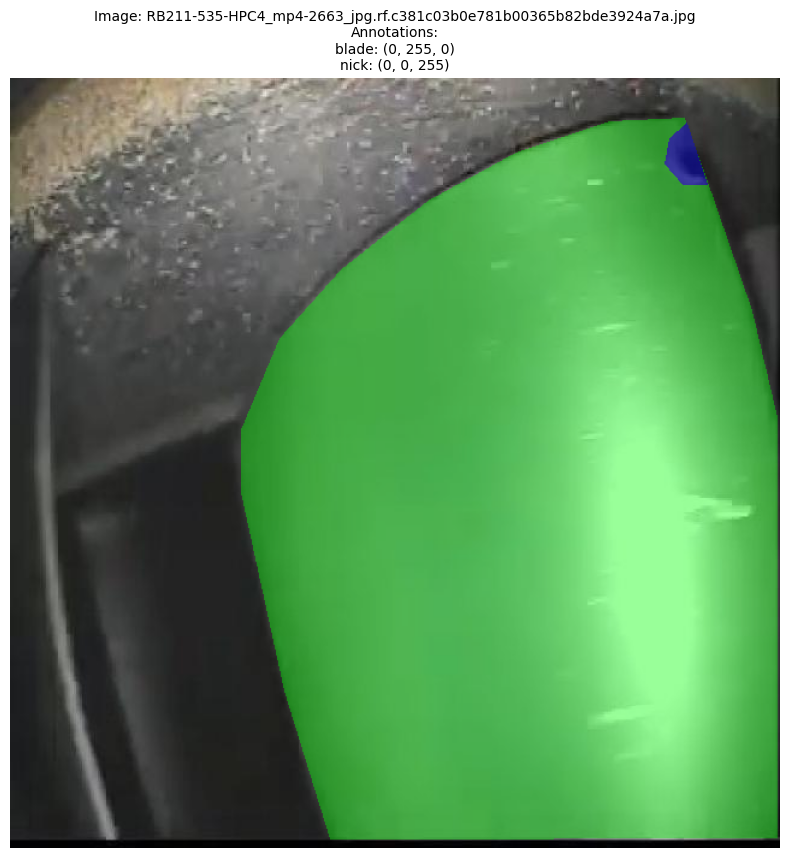

In [30]:
import json
import random
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# 1. 설정: 경로를 확인해주세요.
# ==============================================================================
MASTER_DATA_DIR = Path('C:/EngineBladeAI/EngineInspectionAI_MS/data/master_dataset')
MASTER_IMAGES_DIR = MASTER_DATA_DIR / 'images'
MASTER_JSON_PATH = MASTER_DATA_DIR / 'master_annotations.json'

# ==============================================================================
# 2. 데이터 로드 및 전처리
# ==============================================================================
print("--- Loading master annotations.json ---")
with open(MASTER_JSON_PATH, 'r') as f:
    master_data = json.load(f)

# 카테고리 정보 (ID -> 이름, 색상)
categories = {cat['id']: cat for cat in master_data['categories']}
COLORS = {
    1: (0, 255, 0),    # blade: Green
    2: (255, 0, 0),    # crack: Red
    3: (0, 0, 255),    # nick: Blue
    4: (255, 255, 0)   # tear: Yellow
}

# 빠른 조회를 위해 annotation 맵 생성
annotations_map = {}
for ann in master_data['annotations']:
    img_id = ann['image_id']
    if img_id not in annotations_map:
        annotations_map[img_id] = []
    annotations_map[img_id].append(ann)

print("--- Data loaded successfully ---\n")

# ==============================================================================
# 3. 시각화 실행
# ==============================================================================
# 무작위로 이미지 하나 선택
random_image_info = random.choice(master_data['images'])
image_id = random_image_info['id']
file_name = random_image_info['file_name']

print(f"Visualizing random image: {file_name} (Image ID: {image_id})")

# 이미지 로드
image_path = MASTER_IMAGES_DIR / file_name
image = cv2.imread(str(image_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
overlay = image.copy() # 마스크를 그릴 복사본

# 해당 이미지의 모든 annotation 찾기
image_annotations = annotations_map.get(image_id, [])
print(f"Found {len(image_annotations)} annotations for this image.")

# 마스크 그리기
for ann in image_annotations:
    category_id = ann['category_id']
    segmentation = ann['segmentation'][0]
    
    # segmentation 좌표를 numpy 배열로 변환
    points = np.array(segmentation).reshape((-1, 2)).astype(np.int32)
    
    color = COLORS.get(category_id, (255, 255, 255)) # 기본 흰색
    
    # 반투명 마스크 그리기
    cv2.fillPoly(overlay, [points], color)

# 원본 이미지와 마스크 오버레이 합치기
alpha = 0.4 # 투명도
final_image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

# 범례(Legend) 추가
legend_texts = []
for ann in image_annotations:
    cat_id = ann['category_id']
    cat_name = categories[cat_id]['name']
    if cat_name not in [t.split(':')[0] for t in legend_texts]:
         legend_texts.append(f"{cat_name}: {COLORS[cat_id]}")

# 이미지 출력
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.title(f"Image: {file_name}\nAnnotations:\n" + '\n'.join(legend_texts), fontsize=10)
plt.axis('off')
plt.show()

In [32]:
import json
import os
import shutil
from pathlib import Path
import random
from tqdm import tqdm
import cv2
import numpy as np
import albumentations as A

# ==============================================================================
# 1. 설정
# ==============================================================================
# --- 입력 경로 ---
MASTER_DATA_DIR = Path('C:/EngineBladeAI/EngineInspectionAI_MS/data/master_dataset')
MASTER_IMAGES_DIR = MASTER_DATA_DIR / 'images'
MASTER_JSON_PATH = MASTER_DATA_DIR / 'master_annotations.json'

# --- 출력 경로 ---
FINAL_DATA_DIR = Path('./data/final_dataset_augmented')

# --- 분배 비율 ---
SPLIT_RATIOS = {'train': 0.75, 'valid': 0.15, 'test': 0.1}
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# --- 데이터 증강 설정 ---
AUGMENTATION_COUNT = 2 # 원본 이미지 1개당 생성할 증강 이미지 수

# ==============================================================================
# 2. 데이터 증강 파이프라인 정의 (Albumentations)
# ==============================================================================
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.6),
    A.Blur(blur_limit=(3, 7), p=0.4),
])

# ==============================================================================
# 3. 데이터 로드 및 분배
# ==============================================================================
print("--- 마스터 데이터셋 로딩 ---")
with open(MASTER_JSON_PATH, 'r') as f:
    master_data = json.load(f)

images = master_data['images']
random.shuffle(images)
train_end = int(len(images) * SPLIT_RATIOS['train'])
valid_end = train_end + int(len(images) * SPLIT_RATIOS['valid'])
splits = {'train': images[:train_end], 'valid': images[train_end:valid_end], 'test': images[valid_end:]}

annotations_map = {ann['image_id']: annotations_map.get(ann['image_id'], []) + [ann] for ann in master_data['annotations']}

print("\n--- 새로운 데이터셋 생성 시작 ---")
for split_name, split_images in splits.items():
    print(f"Processing '{split_name}' split...")
    split_data = {'categories': master_data['categories'], 'images': [], 'annotations': []}
    split_img_dir = FINAL_DATA_DIR / split_name / 'images'
    split_img_dir.mkdir(parents=True, exist_ok=True)
    
    new_img_id = 0
    new_ann_id = 0

    for img_info in tqdm(split_images, desc=f"  Processing {split_name} images"):
        # 원본 이미지와 Annotation 추가
        original_anns = annotations_map.get(img_info['id'], [])
        
        # 원본 이미지 정보 업데이트
        new_original_img_info = {**img_info, 'id': new_img_id}
        split_data['images'].append(new_original_img_info)
        
        # 원본 Annotation 정보 업데이트
        for ann in original_anns:
            split_data['annotations'].append({**ann, 'id': new_ann_id, 'image_id': new_img_id})
            new_ann_id += 1
        
        shutil.copy(MASTER_IMAGES_DIR / img_info['file_name'], split_img_dir / img_info['file_name'])
        new_img_id += 1
        
        # --- 학습(train) 데이터에만 증강 적용 ---
        if split_name == 'train':
            image = cv2.imread(str(MASTER_IMAGES_DIR / img_info['file_name']))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # COCO polygon을 Albumentations가 사용할 수 있는 마스크 리스트로 변환
            masks = []
            class_labels = []
            for ann in original_anns:
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
                points = [np.array(poly).reshape((-1, 2)).astype(np.int32) for poly in ann['segmentation']]
                cv2.fillPoly(mask, points, 1)
                masks.append(mask)
                class_labels.append(ann['category_id'])

            # 지정된 횟수만큼 증강 실행
            for i in range(AUGMENTATION_COUNT):
                transformed = transform(image=image, masks=masks)
                transformed_image = transformed['image']
                transformed_masks = transformed['masks']
                
                # 증강된 이미지 정보 추가
                aug_filename = f"{Path(img_info['file_name']).stem}_aug_{i}.jpg"
                aug_img_info = {'id': new_img_id, 'file_name': aug_filename, 'width': image.shape[1], 'height': image.shape[0]}
                split_data['images'].append(aug_img_info)
                
                # 증강된 Annotation 정보 추가
                for t_mask, cat_id in zip(transformed_masks, class_labels):
                    contours, _ = cv2.findContours(t_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    if not contours: continue
                    
                    segmentation = [c.flatten().tolist() for c in contours]
                    x, y, w, h = cv2.boundingRect(contours[0])
                    
                    split_data['annotations'].append({
                        'id': new_ann_id, 'image_id': new_img_id, 'category_id': cat_id,
                        'segmentation': segmentation, 'area': int(np.sum(t_mask)),
                        'bbox': [x, y, w, h], 'iscrowd': 0
                    })
                    new_ann_id += 1
                
                # 증강된 이미지 저장
                save_path = split_img_dir / aug_filename
                cv2.imwrite(str(save_path), cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))
                new_img_id += 1

    # 최종 JSON 파일 저장
    split_json_path = FINAL_DATA_DIR / split_name / 'annotations.json'
    with open(split_json_path, 'w') as f:
        json.dump(split_data, f, indent=2)
        
    print(f"  '{split_name}' split created: {len(split_data['images'])} images, {len(split_data['annotations'])} annotations")

print("\n--- ✅ 최종 데이터셋 생성 완료! ---")
print(f"   - 최종 데이터 경로: {FINAL_DATA_DIR}")

--- 마스터 데이터셋 로딩 ---

--- 새로운 데이터셋 생성 시작 ---
Processing 'train' split...


  Processing train images: 100%|██████████| 2455/2455 [00:54<00:00, 45.05it/s]


  'train' split created: 7365 images, 31454 annotations
Processing 'valid' split...


  Processing valid images: 100%|██████████| 491/491 [00:01<00:00, 258.00it/s]


  'valid' split created: 491 images, 2144 annotations
Processing 'test' split...


  Processing test images: 100%|██████████| 328/328 [00:01<00:00, 268.84it/s]

  'test' split created: 328 images, 1395 annotations

--- ✅ 최종 데이터셋 생성 완료! ---
   - 최종 데이터 경로: data\final_dataset_augmented
